### Many methods to handle PU data exist. Each has its advantagdes and drawbacks. That is why it is important to compare each of them on similar data. 

### Tests with the 'raisin' dataset has already been done but as it has 7 variables, it is difficult to see 'concretely' how it performs. It is why we will do tests on two dimensional data.

### We will create two datasets. A first one with two classes clearly separable, and another one with classes that are closer to one another.

In [1]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cluster import KMeans
!pip install qpsolvers
import qpsolvers
!pip install qpsolvers[cvxopt]
!pip install qpsolvers[open_source_solvers]
!pip install qpsolvers[clarabel]
from qpsolvers import solve_qp
from sklearn.preprocessing import StandardScaler
from scipy.stats import bernoulli
from sklearn.utils import shuffle

In [2]:
def rbf(x,y,l=1):
    """Gaussian kernel

    Parameters
    -------------------------------
    x : float
    a real number

    y : float
    a real number

    l: float, non zero
    a scale parameter
    -------------------------------
    """
    dim = x.shape[0]
    vect = np.empty(dim)
    if dim == y.shape[0]  :
        d = np.exp((-1)*((np.linalg.norm(x-y))/(2*(l**2))))
        return d
    else :
        for i in range(dim):
            vect[i] = np.exp((-1)*(np.linalg.norm(x[i] - y))/(2*(l**2)))
        return vect

In [3]:
def update_cov(X,mean,weights,group):
    """a function to estimate the covariance with a new mean
    Parameter
    -------------------------------
    X : array-like
    the data with which we want to estimate the new covariance

    mean : array-like
    the new mean that doesn't correspond to the 'true mean'

    weights : arrar-like 
    the matrix of weights of the whole data

    group : int
    the group in which we want to update
    --------------------------------
    """
    sum_of_mat = np.zeros((X.shape[1],X.shape[1]))
    for i in range(X.shape[0]):
        temporal_cov = weights[i,group]*np.matmul((X[i,:]-mean).reshape((X.shape[1],1)),
                                                      (X[i,:]-mean).reshape((1,X.shape[1])))
        sum_of_mat += temporal_cov
    sum_of_weights = np.sum(weights[:,group])
    weighted_sigma = sum_of_mat/sum_of_weights
    return weighted_sigma

### Creation of the data

#### The red ones will be the unlabeled/negatives

In [4]:
np.random.seed(1457065)
n_gen = 50
n_samples = 4*n_gen
data_red_1 = np.random.multivariate_normal(mean=np.array([2,2]),
                                             cov=np.array(([1,-0.25],[-0.25,1])),
                                             size=n_gen)
data_red_2 = np.random.uniform(low=1.0, high=3.0, size=(n_gen,2))

data_blue_1 = np.random.multivariate_normal(mean=np.array([-1,-1]),
                                            cov=np.eye(2)*0.5,
                                            size=n_gen)
data_blue_2 = np.random.uniform(low=-2, high=-1, size=(n_gen,2))

data_red = np.vstack((data_red_1,data_red_2))
labels_red = (np.ones(2*n_gen)*-1).reshape(2*n_gen,1)
data_red = np.hstack((data_red,labels_red))

data_blue = np.vstack((data_blue_1, data_blue_2))
labels_blue = (np.ones(2*n_gen)).reshape(2*n_gen,1)
data_blue = np.hstack((data_blue,labels_blue))

whole_data = np.vstack((data_blue, data_red))

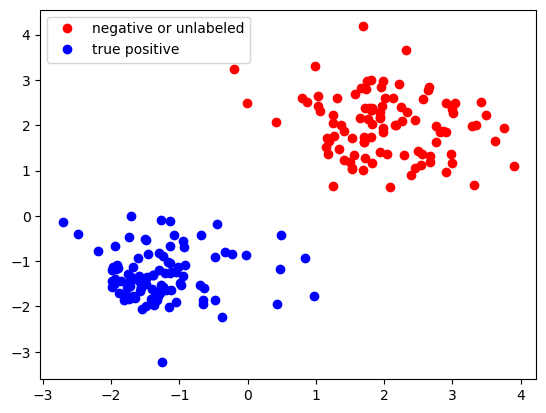

In [5]:
plt.plot(data_red[:,0],data_red[:,1],'or',label='negative or unlabeled')
plt.plot(data_blue[:,0],data_blue[:,1],'ob',label='true positive')
plt.legend()

In [6]:
for i in range(2*n_gen):
    random = bernoulli.rvs(p=3/4)
    if random == 1:
        whole_data[i,2] = -1
positive_data = np.zeros((1,3))
unlabeled_data = np.zeros((1,3))
for i in range(n_samples):
    if whole_data[i,2] == 1:
        positive_data = np.vstack((positive_data, whole_data[i,:]))
    else:
        unlabeled_data = np.vstack((unlabeled_data, whole_data[i,:]))

positive_data = np.delete(positive_data,0,0)
unlabeled_data = np.delete(unlabeled_data,0,0)
pu_data = np.vstack((positive_data,unlabeled_data))

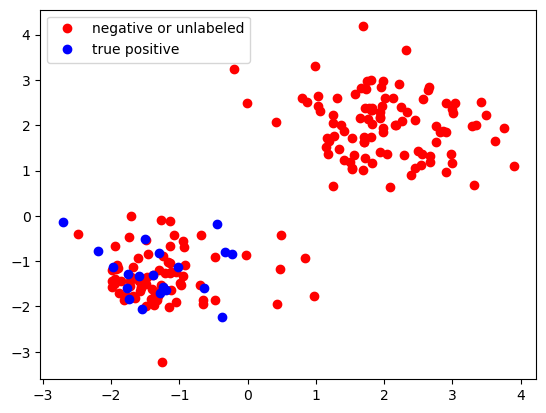

In [7]:
plt.plot(unlabeled_data[:,0],unlabeled_data[:,1],'or',label='negative or unlabeled')
plt.plot(positive_data[:,0],positive_data[:,1],'ob',label='true positive')
plt.legend()

In [8]:
f'{(positive_data.shape[0]*100)/200}% is quite close to our setting for the material science project'

'10.0% is quite close to our setting for the material science project'

### First, lets try with the PGPU approach

In [9]:
pu_data[:,:2],pu_data[:,2] = shuffle(pu_data[:,:2],pu_data[:,2])
pu_data_train = pu_data[:,:2][:int(n_samples*0.8)]
output_train = pu_data[:,2][:int(n_samples*0.8)]
pu_data_test = pu_data[:,:2][int(n_samples*0.8):]
output_test = pu_data[:,2][int(n_samples*0.8):]

In [10]:
svm_estimate = SVC(kernel='sigmoid',probability=True).fit(X=pu_data_train,y=output_train)

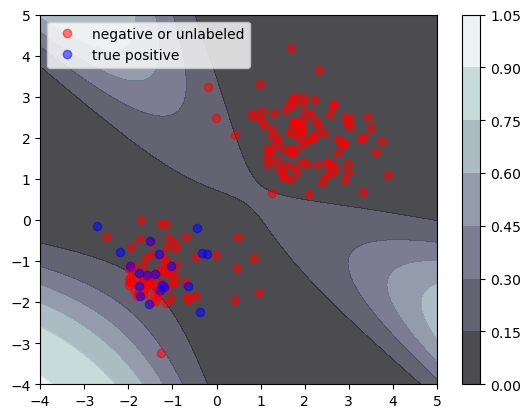

In [11]:
xx, yy = np.meshgrid(np.linspace(-4,5,500), np.linspace(-4,5,500))
Z = svm_estimate.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
plt.plot(unlabeled_data[:,0],unlabeled_data[:,1],'or', alpha=0.5, label='negative or unlabeled')
plt.plot(positive_data[:,0],positive_data[:,1],'ob',alpha=0.5, label='true positive')
plt.legend()
plt.colorbar()
plt.show()

In [12]:
count_positives = 0
for i in range(output_train.shape[0]):
    if output_train[i] == 1:
        count_positives += 1
print(count_positives)

16


In [13]:
probas = svm_estimate.predict_proba(pu_data_train)
probas_gap = probas[:,1] - probas[:,0]

In [14]:
pu_df = pd.DataFrame(pu_data_train)
pu_df.columns = ['x1','x2']
pu_df['proba_gap'] = probas_gap
pu_df['label'] = output_train
pu_df['proba_negative'] = probas[:,0]
pu_df['proba_positive'] = probas[:,1]
pu_df['relab'] = np.zeros(pu_df.shape[0])

In [15]:
l_boundary = np.min(pu_df[pu_df['label'] == 1]['proba_gap'].to_numpy())

In [16]:
l_boundary

-0.8559917132778232

In [17]:
for i in range(pu_df.shape[0]):
    if pu_df.loc[i,'proba_gap'] < l_boundary:
        pu_df.loc[i,'relab'] = -1
    elif pu_df.loc[i,'proba_gap'] > 0:
        pu_df.loc[i,'relab'] = 1
    elif output_train[i] == 1:
        pu_df.loc[i,'relab'] = 1

In [18]:
reliable_negatives = pu_df[pu_df['relab'] == -1]
reliable_positives = pu_df[pu_df['relab'] == 1]
indexes_reliable = reliable_negatives.index.append(reliable_positives.index)

In [19]:
unlabeled_data = pu_df.filter(items=indexes_reliable,axis=0)
unlabeled_data = unlabeled_data[['x1','x2']].copy().to_numpy()

In [20]:
labeled_data = pd.concat([reliable_negatives,reliable_positives])
output_labeled = labeled_data['relab'].to_numpy()
labeled_data  = labeled_data[['x1','x2']].copy().to_numpy()

In [21]:
n_labels = labeled_data.shape[0]
n_unlabeled = unlabeled_data.shape[0]

In [22]:
capital_k = np.zeros((n_labels,n_labels))
kappa = np.zeros(n_labels)

#construction of capital_k
for i in range(n_labels):
    for j in range(i,n_labels):
        capital_k[i,j] = rbf(x=labeled_data[i,:],y=labeled_data[j,:])

capital_k = capital_k + capital_k.T
for i in range(n_labels):
    capital_k[i,i] = 1

capital_k[np.where(np.isnan(capital_k) == True)] = 0

#construction of kappa
ratio_lab_unlab = n_labels/n_unlabeled

for i in range(n_labels):
    vector = np.zeros(n_unlabeled)
    for k in range(n_unlabeled):
        vector[k] = rbf(x=labeled_data[i,:],y=unlabeled_data[k,:])    
    kappa[i] = ratio_lab_unlab*np.sum(vector)

kappa = -kappa

In [23]:
#matrices used to set the optimization problem
B=1000 #as in the article, not said to what it corresponded
ones_transposed = np.ones(n_labels).reshape(1,n_labels)

a_mat = np.vstack((ones_transposed,ones_transposed*-1,
                   np.eye(n_labels),np.eye(n_labels)*-1))

epsilon = (np.sqrt(n_labels)-1)/np.sqrt(n_labels)
ub_mat = np.vstack((n_labels*(1+epsilon),n_labels*(epsilon-1),
                    np.ones(n_labels).reshape(n_labels,1)*B,
                    np.zeros(n_labels).reshape(n_labels,1)))

In [24]:
#optimization pb
beta_opti = solve_qp(P=capital_k,q=kappa,G=a_mat,h=ub_mat,solver='cvxopt')

In [38]:
svm_weighted = SVC().fit(X=labeled_data,y=output_labeled,sample_weight=beta_opti)

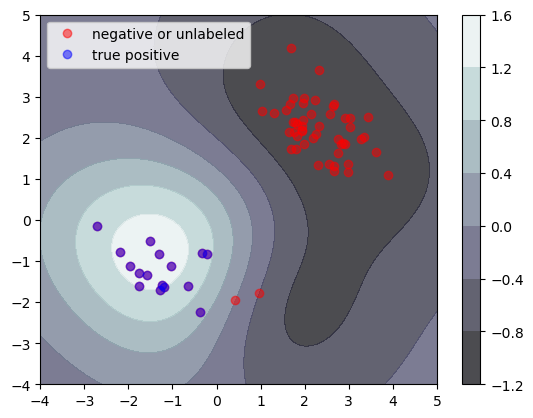

In [39]:
xx, yy = np.meshgrid(np.linspace(-4,5,500), np.linspace(-4,5,500))
Z = svm_weighted.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
plt.plot(unlabeled_data[:,0],unlabeled_data[:,1],'or', alpha=0.5, label='negative or unlabeled')
plt.plot(reliable_positives.to_numpy()[:,0],
         reliable_positives.to_numpy()[:,1],
         'ob',alpha=0.5, label='true positive')
plt.legend()
plt.colorbar()
plt.show()

In [40]:
#and if we now plot it with the whole data

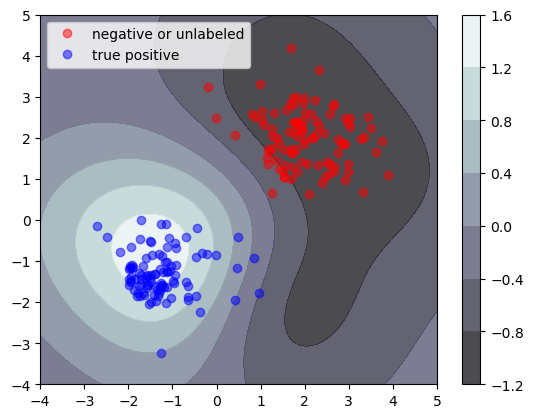

In [53]:
xx, yy = np.meshgrid(np.linspace(-4,5,500), np.linspace(-4,5,500))
Z = svm_weighted.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
plt.plot(data_red[:,0],data_red[:,1],'or', alpha = 0.5,label='negative or unlabeled')
plt.plot(data_blue[:,0],data_blue[:,1],'ob',alpha = 0.5,label='true positive')
plt.legend()
plt.colorbar()
plt.show()

In [42]:
#let's now check the test

In [61]:
n_gen_test = 10
n_samples_test = 4*n_gen_test
data_n_test_1 = np.random.multivariate_normal(mean=np.array([2,2]),
                                             cov=np.array(([1,-0.25],[-0.25,1])),
                                             size=n_gen_test)
data_n_test_2 = np.random.uniform(low=1.0, high=3.0, size=(n_gen_test,2))

data_p_test_1 = np.random.multivariate_normal(mean=np.array([-1,-1]),
                                            cov=np.eye(2)*0.5,
                                            size=n_gen_test)
data_p_test_2 = np.random.uniform(low=-2, high=-1, size=(n_gen_test,2))

data_test = np.vstack((data_n_test_1,data_n_test_2,data_p_test_1,data_p_test_2))
data_test = np.hstack((data_test,np.hstack((np.ones(n_gen_test*2)*(-1),np.ones(n_gen_test*2))).reshape(n_samples_test,1)))

positive_prediction_test = 0
true_positive_prediction_test = 0
predictions_test = svm_weighted.predict(data_test[:,:2])
for i in range(data_test.shape[0]):
    if predictions_test[i] == 1:
        positive_prediction_test += 1
        if data_test[i,2] == 1:
            true_positive_prediction_test += 1

print('the precision on the test data is : ', true_positive_prediction_test/positive_prediction_test)

the precision on the test data is :  1.0


In [64]:
#so it is perfect but the data was clearly separable

In [65]:
#let's now try with a less separable dataset